### Week 4 notebook

Each week, you will apply the concepts of that week to your Integrated Capstone Project’s dataset. In preparation for Milestone One, create a Jupyter Notebook (similar to in Module B, semester two) that illustrates these lessons. There are no specific questions to answer in your Jupyter Notebook files in this course; your general goal is to analyze your data using the methods you have learned about in this course and in this program and draw interesting conclusions. 

For Week 4, include concepts such as logistic regression and feature scaling. This homework should be submitted for peer review in the assignment titled 4.3 Peer Review: Week 4 Jupyter Notebook. Complete and submit your Jupyter Notebook homework by 11:59pm ET on Sunday. 

In Week 7, you will compile your findings from your Jupyter Notebook homework into your Milestone One assignment for grading. For full instructions and the rubric for Milestone One, refer to the following link. 

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# Import feature engineering and selection libraries
from sklearn.linear_model import LogisticRegression, LinearRegression

# data preprocesing and scoring
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_squared_error, ConfusionMatrixDisplay, confusion_matrix, accuracy_score

random_state = 0

In [2]:
# encode categorical features
def encode_categories(df: pd.DataFrame):
    df_encoded = df.copy()
    mappings = {}
    cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
    
    for col in cat_cols:
        # get the unique categories (in order of appearance)
        uniques = df_encoded[col].dropna().unique().tolist()
        # build a mapping: category -> code
        mapping = {cat: code for code, cat in enumerate(uniques)}
        mappings[col] = mapping

        # map (leave NaN as NaN)
        df_encoded[col] = df_encoded[col].map(mapping).astype("int64")

    return df_encoded, mappings

In [3]:
# Create a function to load and split data
def load_and_split_data(file_path, test_size=0.2, random_state=0, choice='norm'):

    # Read and Encode catigorical features
    df, _ = encode_categories(pd.read_csv(file_path))

    # Feature and target
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Train and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    if choice == 'reg':
        # Regularize the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Convert scaled features back to DataFrames
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

    else:
        # Bormalize the features
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Convert scaled features back to DataFrames
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

    return X_train_scaled, X_test_scaled, y_train, y_test, df

### Model Functions

In [4]:
def lin_regression(X_train, y_train, X_test, y_test, type='class'):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if type == 'reg':
        score = root_mean_squared_error(y_test, y_pred)
    else:
        score = accuracy_score(y_test, y_pred)
    # print(f"Root Mean Squared Error: {rmse:.4f}")
    return model, y_pred, score

In [5]:
def log_regression(X_train, y_train, X_test, y_test, type='class'):
    model = LogisticRegression(random_state=random_state, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if type == 'reg':
        score = root_mean_squared_error(y_test, y_pred)
    else:
        score = accuracy_score(y_test, y_pred)
    # print(f"Root Mean Squared Error: {rmse:.4f}")
    return model, y_pred, score

In [6]:
X_train_car_reg, X_test_car_reg, y_train_car_reg, y_test_car_reg, df_car_reg = load_and_split_data(r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\carclaims_cleaned.csv', choice='reg')
X_train_ins_reg, X_test_ins_reg, y_train_ins_reg, y_test_ins_reg, df_ins_reg = load_and_split_data(r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\insurance_claims_cleaned.csv', choice='reg')
X_train_fur_reg, X_test_fur_reg, y_train_fur_reg, y_test_fur_reg, df_fur_reg = load_and_split_data(r'C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\Fast_Furious_Insured\train_cleaned.csv', choice='reg')

In [7]:
X_train_car_norm, X_test_car_norm, y_train_car_norm, y_test_car_norm, df_car_norm = load_and_split_data(r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\carclaims_cleaned.csv', choice='norm')
X_train_ins_norm, X_test_ins_norm, y_train_ins_norm, y_test_ins_norm, df_ins_norm = load_and_split_data(r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\insurance_claims_cleaned.csv', choice='norm')
X_train_fur_norm, X_test_fur_norm, y_train_fur_norm, y_test_fur_norm, df_fur_norm = load_and_split_data(r'C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\Fast_Furious_Insured\train_cleaned.csv', choice='norm')

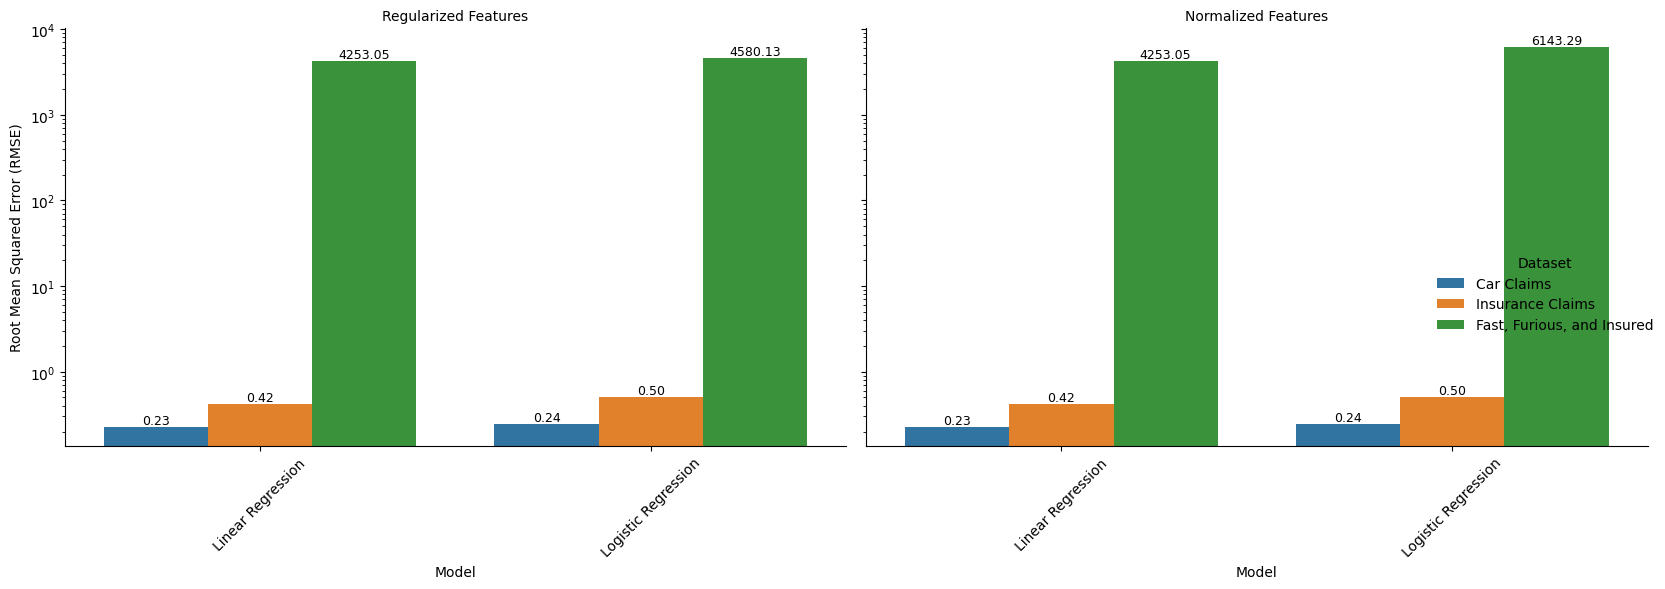

In [8]:
# Run linear and logistic regression on all datasets and plot results as a grouped bar chart

# Linear Regression regularized
model_car_lin_reg, y_pred_car_lin_reg, car_lin_rmse_reg = lin_regression(X_train_car_reg, y_train_car_reg, X_test_car_reg, y_test_car_reg, type = 'reg')
model_ins_lin_reg, y_pred_ins_lin_reg, ins_lin_rmse_reg = lin_regression(X_train_ins_reg, y_train_ins_reg, X_test_ins_reg, y_test_ins_reg, type = 'reg')
model_fur_lin_reg, y_pred_fur_lin_reg, fur_lin_rmse_reg = lin_regression(X_train_fur_reg, y_train_fur_reg, X_test_fur_reg, y_test_fur_reg, type = 'reg')

# Logistic Regression regularized
model_car_log_reg, y_pred_car_log_reg, car_log_rmse_reg = log_regression(X_train_car_reg, y_train_car_reg, X_test_car_reg, y_test_car_reg, type = 'reg')
model_ins_log_reg, y_pred_ins_log_reg, ins_log_rmse_reg = log_regression(X_train_ins_reg, y_train_ins_reg, X_test_ins_reg, y_test_ins_reg, type = 'reg')
model_fur_log_reg, y_pred_fur_log_reg, fur_log_rmse_reg = log_regression(X_train_fur_reg, y_train_fur_reg, X_test_fur_reg, y_test_fur_reg, type = 'reg')

# Linear Regression normalized
model_car_lin_norm, y_pred_car_lin_norm, car_lin_rmse_norm = lin_regression(X_train_car_norm, y_train_car_norm, X_test_car_norm, y_test_car_norm, type = 'reg')
model_ins_lin_norm, y_pred_ins_lin_norm, ins_lin_rmse_norm = lin_regression(X_train_ins_norm, y_train_ins_norm, X_test_ins_norm, y_test_ins_norm, type = 'reg')
model_fur_lin_norm, y_pred_fur_lin_norm, fur_lin_rmse_norm = lin_regression(X_train_fur_norm, y_train_fur_norm, X_test_fur_norm, y_test_fur_norm, type = 'reg')

# Logistic Regression normalized
model_car_log_norm, y_pred_car_log_norm, car_log_rmse_norm = log_regression(X_train_car_norm, y_train_car_norm, X_test_car_norm, y_test_car_norm, type = 'reg')
model_ins_log_norm, y_pred_ins_log_norm, ins_log_rmse_norm = log_regression(X_train_ins_norm, y_train_ins_norm, X_test_ins_norm, y_test_ins_norm, type = 'reg')
model_fur_log_norm, y_pred_fur_log_norm, fur_log_rmse_norm = log_regression(X_train_fur_norm, y_train_fur_norm, X_test_fur_norm, y_test_fur_norm, type = 'reg')

# Prepare results for plotting with a 'Type' column
results = pd.DataFrame({
    'Dataset': ['Car Claims', 'Car Claims', 'Insurance Claims', 'Insurance Claims', 'Fast, Furious, and Insured', 'Fast, Furious, and Insured'] * 2,
    'Model': ['Linear Regression', 'Logistic Regression'] * 6,
    'RMSE': [
        car_lin_rmse_reg, car_log_rmse_reg, ins_lin_rmse_reg, ins_log_rmse_reg, fur_lin_rmse_reg, fur_log_rmse_reg,
        car_lin_rmse_norm, car_log_rmse_norm, ins_lin_rmse_norm, ins_log_rmse_norm, fur_lin_rmse_norm, fur_log_rmse_norm
    ],
    'Type': ['Regularized'] * 6 + ['Normalized'] * 6
})

model_order = ['Linear Regression', 'Logistic Regression']
results['Model'] = pd.Categorical(results['Model'], categories=model_order, ordered=True)

# Plot with columns for Regularized and Normalized
g = sns.catplot(
    data=results,
    x='Model',
    y='RMSE',
    hue='Dataset',
    col='Type',
    kind='bar',
    height=6,
    aspect=1.2,
    dodge=True
)
g.set_titles("{col_name} Features")
g.set_axis_labels('Model', 'Root Mean Squared Error (RMSE)')
g.set_xticklabels(rotation=45)
g._legend.set_title('Dataset')

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)

for ax in g.axes.flat:
    ax.set_yscale('log')

plt.tight_layout()
plt.show()

Comparing the results of the linear and logistic regression models is difficult since I have a mixture of regression and classification type datasets. The car claims and insurance claims datasets, which are both classification types, seemed to perform better on the linear regression model. The fast, furious, and insured dataset is a regression type, and also performed better on the linear regression model. The latter makes more sense since linear regression is more suited to that dataset. On the classification datasets, logistic regression is more appropriate, even if linear regression sometimes shows a lower RMSE—this is likely due to the metric not being ideal for classification.

The following charts will account for the correct metrics for each classification dataset problem.

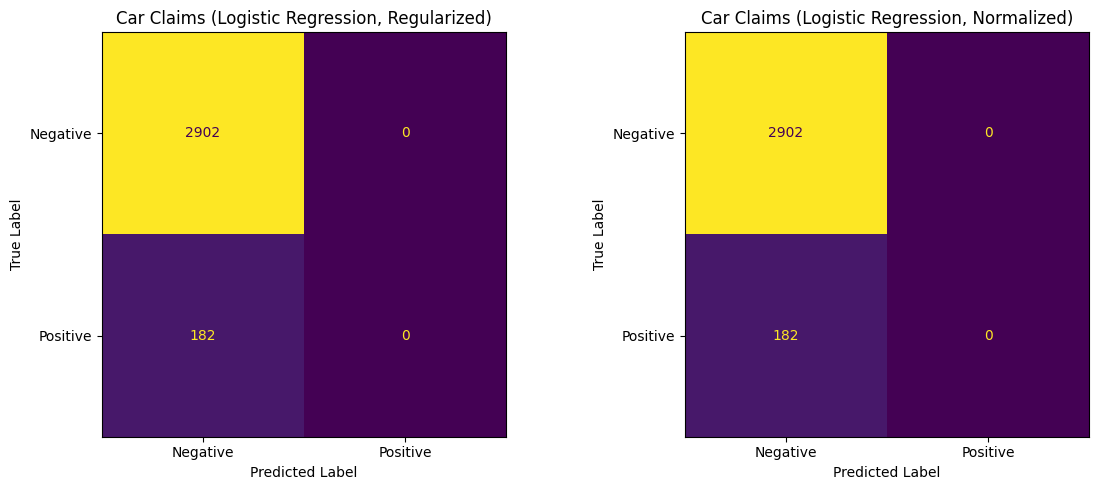

In [10]:
# Car Claims - Logistic Regression (Regularized vs Normalized) in the same figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Regularized
cm_car_log_reg = confusion_matrix(y_test_car_reg, y_pred_car_log_reg)
disp_car_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_car_log_reg, display_labels=['Negative', 'Positive'])
disp_car_log_reg.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Car Claims (Logistic Regression, Regularized)")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Normalized
cm_car_log_norm = confusion_matrix(y_test_car_norm, y_pred_car_log_norm)
disp_car_log_norm = ConfusionMatrixDisplay(confusion_matrix=cm_car_log_norm, display_labels=['Negative', 'Positive'])
disp_car_log_norm.plot(ax=axes[1], colorbar=False)
axes[1].set_title("Car Claims (Logistic Regression, Normalized)")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

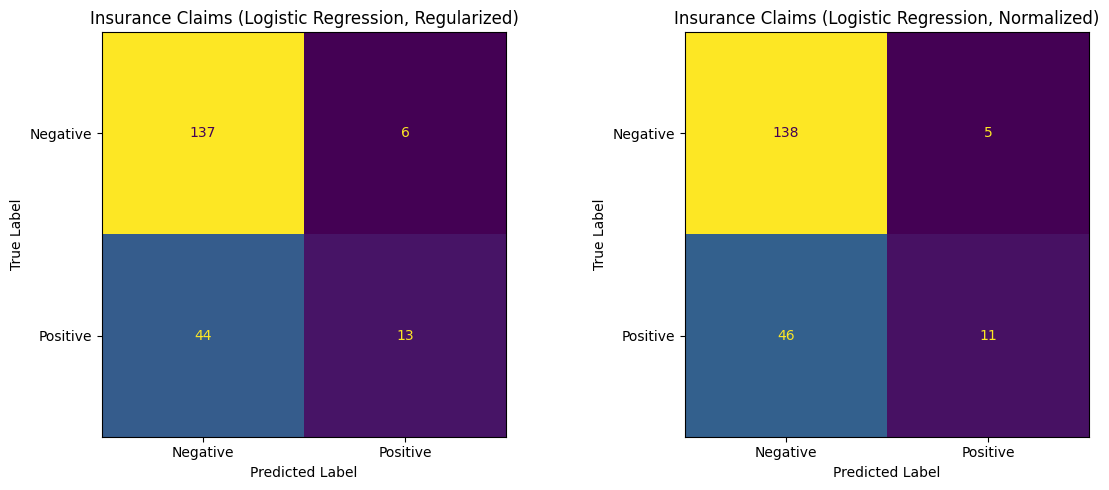

In [11]:
# Insurance Claims - Logistic Regression (Regularized vs Normalized) in the same figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Regularized
cm_ins_log_reg = confusion_matrix(y_test_ins_reg, y_pred_ins_log_reg)
disp_ins_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_ins_log_reg, display_labels=['Negative', 'Positive'])
disp_ins_log_reg.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Insurance Claims (Logistic Regression, Regularized)")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Normalized
cm_ins_log_norm = confusion_matrix(y_test_ins_norm, y_pred_ins_log_norm)
disp_ins_log_norm = ConfusionMatrixDisplay(confusion_matrix=cm_ins_log_norm, display_labels=['Negative', 'Positive'])
disp_ins_log_norm.plot(ax=axes[1], colorbar=False)
axes[1].set_title("Insurance Claims (Logistic Regression, Normalized)")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

Looking at the comparison of Regularized to Normalized datasets, there was not change in the prediction of the Car claims dataset. Also, both Logistic Regression models were unable to predict negative cases, this must be a fault in the datasplit as there indeed negative cases in the data. The Insurance Claims dataset had slight variations in its predictions. The Normalized dataset identified more False Negative cases of FraudFound, and less cases of False Positives.